# Genetics Project

## Step 1: Setting the environment

In [122]:
# Import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2

In [123]:
# Clean VCF

vcf_path = f"data/genotypes.vcf"
ann_path = f"data/annotations.txt"

# Get headers
with open(vcf_path, "r") as f:
    for line in f:
        if line.startswith("#CHROM"):
            header = line.strip().lstrip("#").split("\t")
            break

# Load VCF
vcf_df = pd.read_csv(
    vcf_path,
    sep="\t",
    comment="#",
    header=None,
    names=header,
    low_memory=False
)

# Non-sample columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]

# Sample columns (all individuals)
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Remove everything except the first item before ':'
for col in sample_cols:
    vcf_df[col] = vcf_df[col].astype(str).str.split(":").str[0]

### 1a. Exploratory data analysis

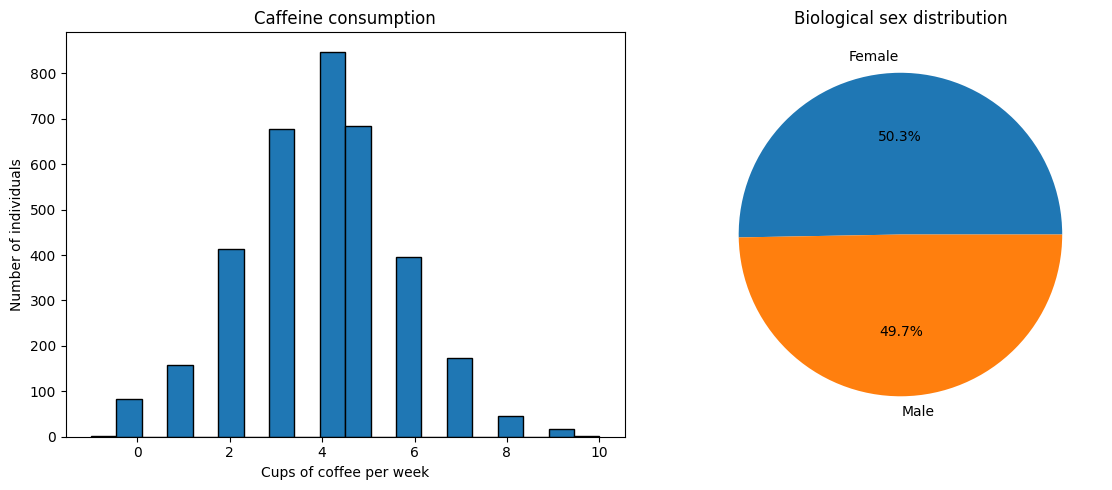

In [124]:
# Plot histogram of caffeine consumption and pie chart for distribution of biological sex

annotations = pd.read_csv(ann_path, sep="\t")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Histogram of caffeine consumption
axes[0].hist(annotations["CaffeineConsumption"], bins=20, edgecolor="black")
axes[0].set_xlabel("Cups of coffee per week")
axes[0].set_ylabel("Number of individuals")
axes[0].set_title("Caffeine consumption")

# Right: pie chart with Male/Female labels
sex_counts = annotations["isFemale"].value_counts()

axes[1].pie(
    sex_counts,
    labels=[("Female" if str(x).lower() == "true" else "Male") for x in sex_counts.index],
    autopct="%1.1f%%"
)
axes[1].set_title("Biological sex distribution")

plt.tight_layout()
plt.show()

## Step 2: SNP-level filtering - call rate

### 2a. Calculate call rate for each SNP and plot histogram of call rates

In [125]:
# Calculate call rate for each SNP

#Identify sample genotype columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Compute call rate
is_called = (vcf_df[sample_cols] != "./.")
call_rate = is_called.sum(axis=1) / len(sample_cols)
vcf_df = vcf_df.copy()
vcf_df["call_rate"] = call_rate

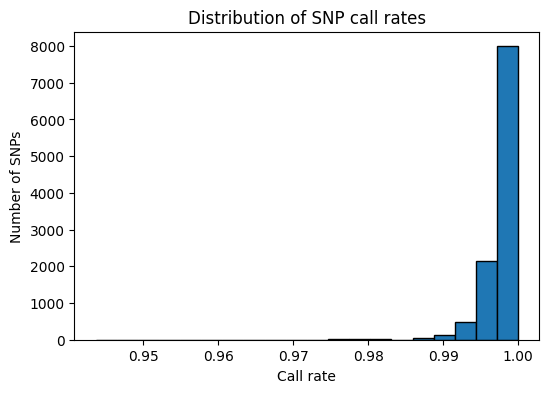

In [126]:
# Plot histogram of call rates

plt.figure(figsize=(6,4))
plt.hist(call_rate, bins=20, edgecolor="black")
plt.xlabel("Call rate")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP call rates")
plt.show()

In [127]:
# Keep variants with call rate = 1.0

vcf_filtered = vcf_df[vcf_df["call_rate"] == 1.0]
num_removed = len(vcf_df) - len(vcf_filtered)
print("Number of removed variants due to incomplete data: " + str(num_removed))

Number of removed variants due to incomplete data: 2888


**Answer**: The amount of removed variants is 2888.

## Step 3: SNP-level filtering - minor allele frequency (MAF)

### 3a. Calculate MAF for each SNP and plot histogram of MAFs for all SNPs

In [128]:
#Function to convert the genotypes to numeric values
def gt_to_num(gt):
    if gt == "0/0":
        return 0
    elif gt in ["0/1", "1/0"]:
        return 1
    elif gt == "1/1":
        return 2
    else:
        return np.nan

In [129]:
# Calculating MAF for each SNP

# Convert GT to numeric
geno_numeric = vcf_filtered[sample_cols].map(gt_to_num)

# Allele frequency
allele_count = geno_numeric.sum(axis=1)
called = geno_numeric.notna().sum(axis=1)
allele_total = 2 * called
freq = allele_count / allele_total

# Minor allele frequency
maf = np.where(freq <= 0.5, freq, 1 - freq)
vcf_filtered = vcf_filtered.copy()
vcf_filtered["MAF"] = maf

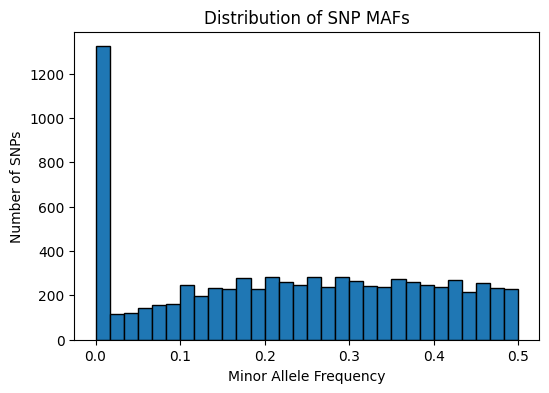

In [130]:
# Plot histogram of all MAFs for all SNPs

plt.figure(figsize=(6,4))
plt.hist(maf, bins=30, edgecolor="black")
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP MAFs")
plt.show()

In [131]:
# Remove variants whose MAF <= 5%

vcf_maf_filtered = vcf_filtered[maf > 0.05]
geno_numeric_filtered = vcf_maf_filtered[sample_cols].map(gt_to_num)
num_removed_maf = len(vcf_filtered) - len(vcf_maf_filtered)
print("Number of removed variants due to low MAF: " + str(num_removed_maf))


Number of removed variants due to low MAF: 1559


**Answer:** There are 1559 SNPs whose MAF was less than or equal to 5% and that were therefore removed. The histogram shows a very large spike of SNPs at a very low MAF, followed by a fairly uniform distribution of MAFs between 0.05 and 0.5.

The large spike means that many SNPs are very rare variants that are only present in a few individuals. This is expected because most new mutations came about recently and exist at low frequency.

Common SNPs in the population are spread fairly evenly across different allele frequencies, so once you move past the rare variants, the MAF distribution becomes roughly uniform.

## Step 4: GWAS on the full study cohort

### 4a: Explore potential effect of biological sex on caffeine consumption


#### i. Plot boxplot and density plot showing distribution of caffeine consumption by biological sex

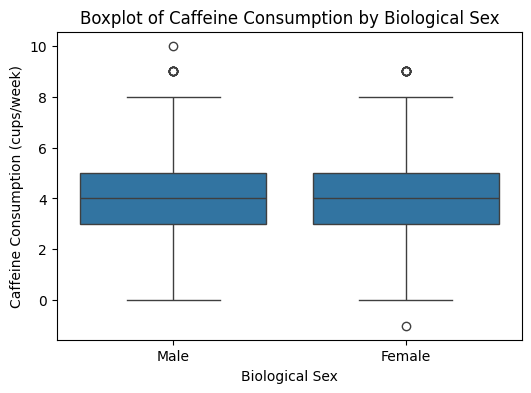

In [132]:
# Plot boxplot

plt.figure(figsize=(6,4))
sns.boxplot(
    data=annotations,
    x="isFemale",
    y="CaffeineConsumption"
)
plt.xticks([0,1], ["Male", "Female"])
plt.xlabel("Biological Sex")
plt.ylabel("Caffeine Consumption (cups/week)")
plt.title("Boxplot of Caffeine Consumption by Biological Sex")
plt.show()

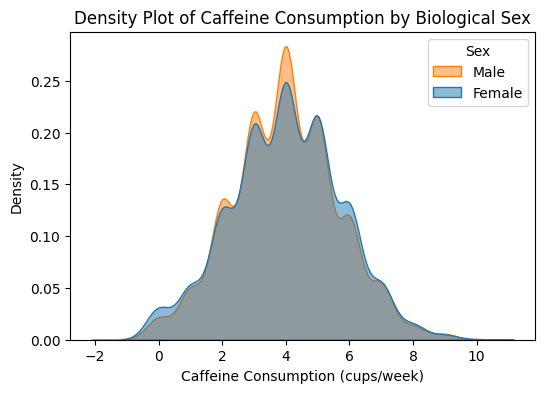

In [133]:
# Plot density plot

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.legend(title="Sex", labels=["Male", "Female"])
plt.xlabel("Caffeine Consumption (cups/week)")
plt.title("Density Plot of Caffeine Consumption by Biological Sex")
plt.show()

#### ii. Use linear regression to test relationship between caffeine consumption and biological sex

In [134]:
# Linear regression
ann_df = annotations[["CaffeineConsumption", "isFemale"]].dropna()
caffeine_sex_X = ann_df["isFemale"].map({True: 1, False: 0})
caffeine_sex_y = ann_df["CaffeineConsumption"]

# Add constant for intercept
caffeine_sex_X = sm.add_constant(caffeine_sex_X)

# Fit OLS regression
caffeine_sex_model = sm.OLS(caffeine_sex_y, caffeine_sex_X).fit()

# Show regression summary
# print(lr_model.summary())
print("Intercept coefficient: " + str(round(caffeine_sex_model.params.const, 3)))
print("Slope coefficient: " + str(round(caffeine_sex_model.params.isFemale, 3)))
print("R^2: " + str(caffeine_sex_model.rsquared))
print("p-value: " + str(round(caffeine_sex_model.pvalues.isFemale, 3)))

Intercept coefficient: 3.992
Slope coefficient: -0.015
R^2: 1.8596649948521282e-05
p-value: 0.799


**Answer:** We should not include biological sex as a covariate in our analysis because it has virtually no effect on caffeine consumption. This is shown by the very low R^2 value and high p-value, which indicate no meaningful or significant association.

### 4b. Population structure

#### i. Calculate principal components of genotype matrix and plot 1st and 2nd PCs

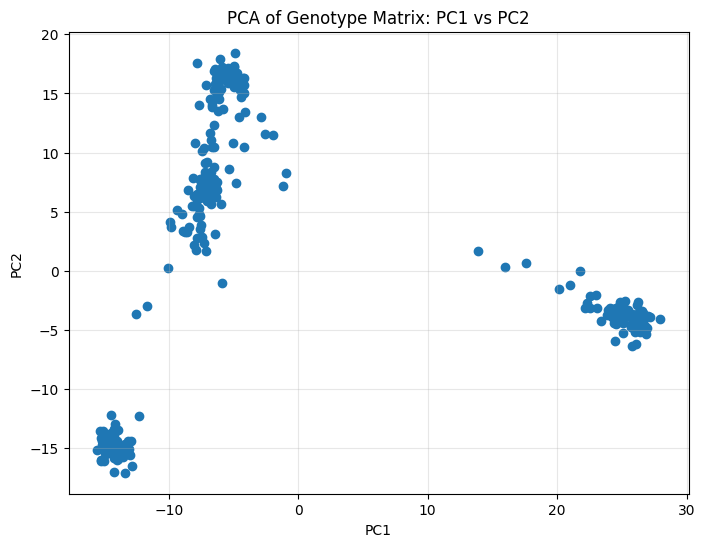

In [135]:
# Run PCA and keep only the first 2 principal components
pca = decomposition.PCA(n_components=2)

#Transpose the genotype matric\x
pcs = pca.fit_transform(geno_numeric_filtered.transpose())

#Store PC1 and PC2 in a dataframe
pc_df = pd.DataFrame({
    'PC1': pcs[:, 0],
    'PC2': pcs[:,1]
})

#Scatterplot of PC1 vs PC2
plt.figure(figsize=(8,6))
plt.scatter(pc_df['PC1'], pc_df['PC2'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix: PC1 vs PC2")
plt.grid(alpha=0.3)
plt.show()

#### ii. Number of data clusters

**Answer:** We can observe 3 data clusters with PC1 and PC2. One cluster appears on the right side of the plot, another in the upper-left region, and a third in the lower-left region. 

These clusters show differences in genetic ancestry, since PCA captures variation in allele frequencies across superpopulations, and individuals with similar ancestries group together in PC space.

We should correct for population structure because ancestry could be a confounding factor in further GWAS and could cause false associations.

### 4c. Run GWAS without covariate correction

#### i. Use linear regression to test association between SNPs and caffeine consumption

#### ii. Extract coefficient of association and p-value for each SNP

In [136]:
# Keep only samples with caffeine comsumption values and index by sample ID
ann_df = annotations[["Sample", "CaffeineConsumption"]].dropna()
ann_df = ann_df.set_index("Sample")
no_correction_y = ann_df["CaffeineConsumption"]

# Lists to store GWAS results
no_correction_betas = []
no_correction_pvals = []

# Genotype matrix as samples x SNPs
snps = geno_numeric_filtered.transpose().columns.tolist()

# Run regression for each SNP
for snp in snps:
    no_correction_x = geno_numeric_filtered.transpose()[snp]
    tmp_df = pd.DataFrame({'y': no_correction_y, 'x': no_correction_x}).dropna()
    
    # Skip SNPs with no variation
    if tmp_df['x'].nunique() < 2:
        no_correction_betas.append(np.nan)
        no_correction_pvals.append(np.nan)
        continue
    
    # Fit linear regression
    no_correction_X = sm.add_constant(tmp_df['x'])
    no_correction_model = sm.OLS(tmp_df['y'], no_correction_X).fit()

    # Store effect size and p value
    no_correction_betas.append(no_correction_model.params['x'])
    no_correction_pvals.append(no_correction_model.pvalues['x'])

# Collect results into a dataframe
no_correction_results = pd.DataFrame({
    'SNP': snps,
    'beta': no_correction_betas,
    'pval': no_correction_pvals
}).set_index("SNP")

### 4d. Produce a Manhattan plot

#### i. Produce scatterplot with variant's linear position on x-axis and significance of association on y-axis

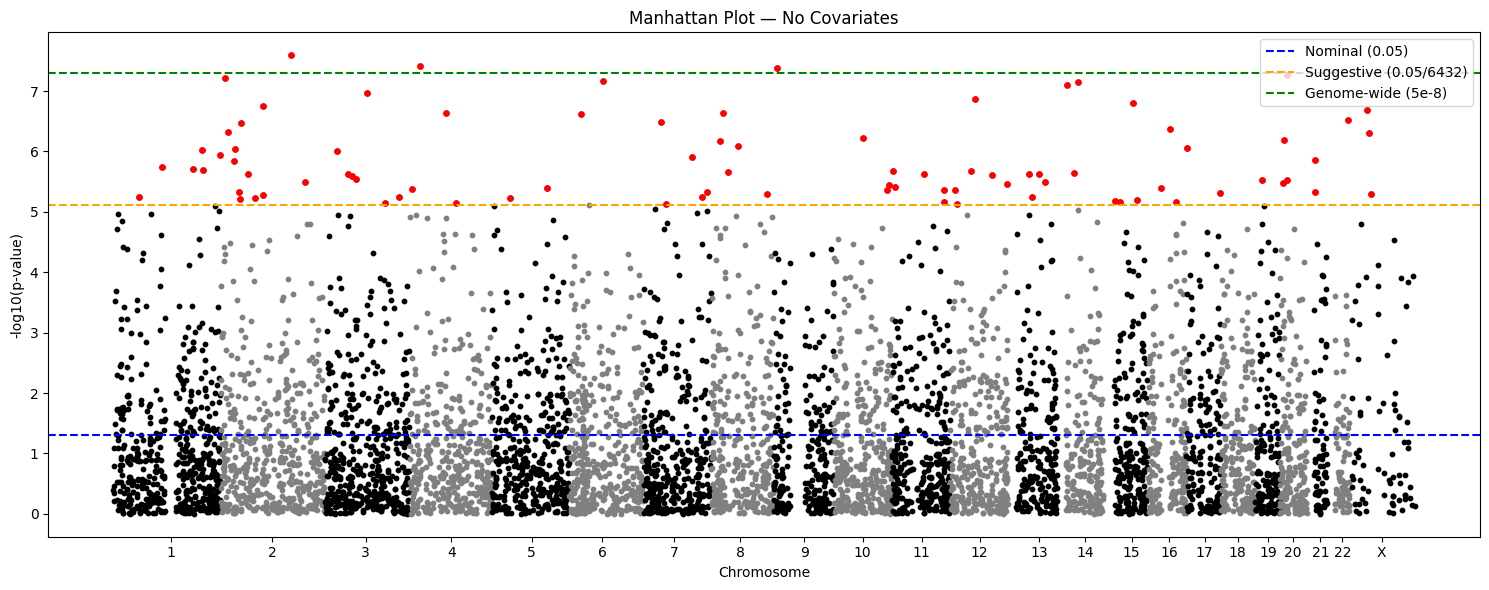

In [137]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = no_correction_results['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — No Covariates")
plt.legend()
plt.tight_layout()
plt.show()

#### ii. How many SNPs pass each threshold? Explain the results

In [138]:
# Count SNPs passing different significance thresholds

n_nominal = (df["pval"] < p_nominal).sum()
n_suggestive = (df["pval"] < p_suggestive).sum()
n_genomewide = (df["pval"] < p_genomewide).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 2109
SNPs passing suggestive (p < 0.05/N): 86
SNPs passing genome-wide (p < 5e-8): 3


**Nominal significance:**
    Under the null hypothesis, we expect around 5% of SNPS (around 320) to be nominally significant by chance alone. But we observed 2109, which is over 6 times more than expected. The fact that many more SNPs than expected pass the nominal threshold suggests that the test statistics are biased, most likely due to uncorrected population structure. Therefore, nominal significance alone is not reliable here.

**Suggestive threshold:**
    In a well-controlled GWAS, SNPs that pass the suggestive threshold show stronger evidence of association than expected by chance alone. In this case, there are 86. However, since the analysis hasn't corrected for ancestry, these SNPs may reflect population structure rather than true associations with caffeine consumption.


**Genome-wide significance:**
    Three SNPs meet the conventional genome-wide significance threshold. This would typically mean that these variants show very strong statistical evidence of association with caffeine consumption, strong enough that they would be considered credible candidate SNPs in a typical GWAS. However, since the analysis is still uncorrected for ancestry differences, we cannot be sure that these SNPs truly influence caffeine intake.

### 4e. Repeat GWAS and Manhattan plot, correcting for covariates based on top 10 PCs

In [139]:
# PCA with 10 components
geno_df_for_pca = geno_numeric_filtered.transpose()
ann_df_for_pca = annotations.set_index("Sample")
ann_sub = ann_df_for_pca.loc[geno_df_for_pca.index]

pca10 = decomposition.PCA(n_components=10, svd_solver="full", random_state=0)
pcs10 = pca10.fit_transform(geno_df_for_pca)
pc_10df = pd.DataFrame(
    pcs10,
    columns=[f"PC{i}" for i in range(1, 11)]
)
pc_10df.insert(0, "Sample", ann_sub.index.values)
pc_10df = pc_10df.set_index("Sample")

In [140]:
# Perform GWAS

df = ann_sub.join(pc_10df).join(geno_df_for_pca)

snp_cols = geno_df_for_pca.columns  # all SNP names
betas = []
pvals = []
snps = []

for snp in snp_cols:

    temp = df[[snp, "CaffeineConsumption"] + [f"PC{i}" for i in range(1,11)]].dropna()

    # Skip monomorphic SNPs
    if temp[snp].nunique() < 2:
        betas.append(np.nan)
        pvals.append(np.nan)
        snps.append(snp)
        continue

    y = temp["CaffeineConsumption"]
    X = temp[[snp] + [f"PC{i}" for i in range(1,11)]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    betas.append(model.params[snp])
    pvals.append(model.pvalues[snp])
    snps.append(snp)

gwas_pc = pd.DataFrame({
    "SNP": snps,
    "beta": betas,
    "pval": pvals
}).set_index("SNP")

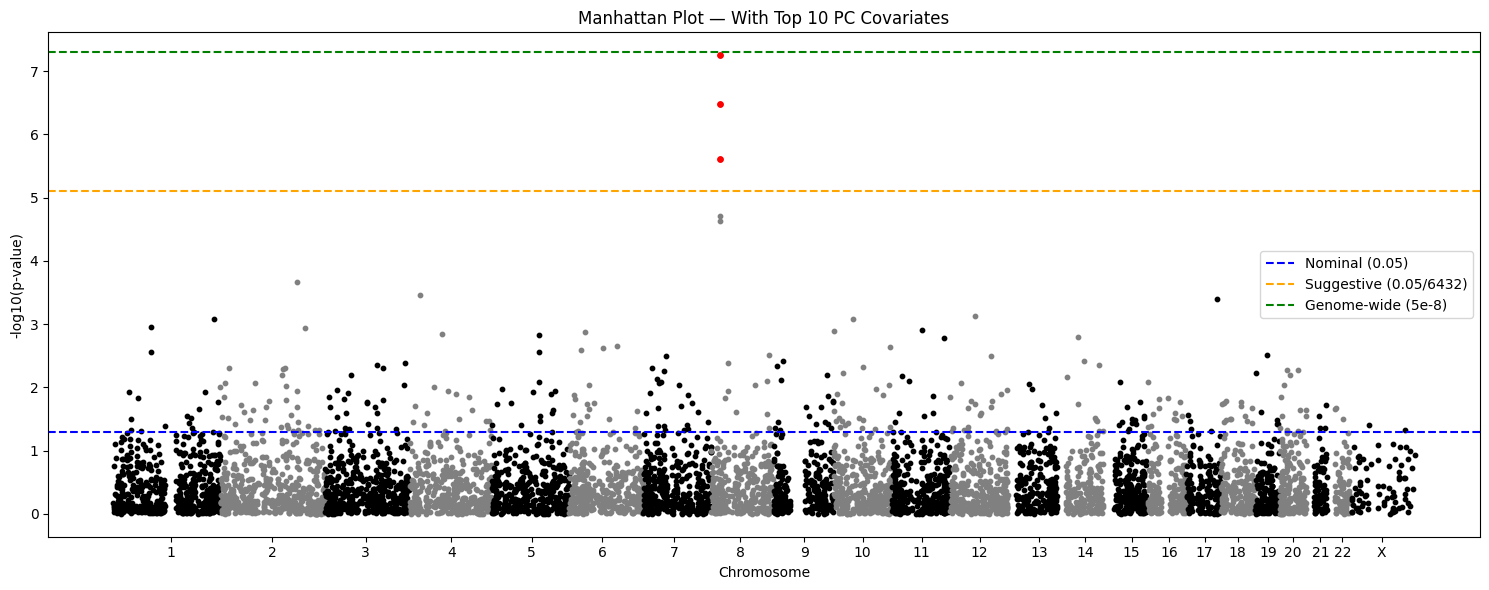

In [141]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = gwas_pc['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — With Top 10 PC Covariates")
plt.legend()
plt.tight_layout()
plt.show()

In [142]:
# Count SNPs passing different significance thresholds

N = gwas_pc.shape[0]
n_nominal = (gwas_pc["pval"] < 0.05).sum()
n_suggestive = (gwas_pc["pval"] < 0.05 / N).sum()
n_genomewide = (gwas_pc["pval"] < 5e-8).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 310
SNPs passing suggestive (p < 0.05/N): 3
SNPs passing genome-wide (p < 5e-8): 0


#### i. How does correcting for the top 10 PCs change the results?

**Answer:** After including the top 10 PCs as covariates, the number of significant SNPs decreased by a lot, and all genome-wide significant associations disappeared. This shows that many apparent SNP associations in the uncorrected analysis were driven by population structure rather than true genetic relationships to caffeine consumption.

#### ii. Report the p-value and Beta for the most significant SNP

In [143]:
best = gwas_pc.loc[gwas_pc["pval"].idxmin()]
print("Most significant SNP (PC corrected):")
print(best)

Most significant SNP (PC corrected):
beta    8.045174e-01
pval    5.588198e-08
Name: 5112, dtype: float64


### 4f. Repeat GWAS and Manhattan plot, correcting for SuperPopulation

In [144]:
# Perform GWAS

df = ann_sub.join(geno_df_for_pca)

snp_cols = geno_df_for_pca.columns  # all SNP names
betas = []
pvals = []
snps = []

# Convert SuperPopulation into one-hot encoded covariates
supop_dummies = pd.get_dummies(df["SuperPopulation"], drop_first=True)
supop_dummies = supop_dummies.astype(int)

# Add these columns to df
for col in supop_dummies.columns:
    df[col] = supop_dummies[col]

covars = supop_dummies.columns.tolist()

for snp in snp_cols:

    temp = df[[snp, "CaffeineConsumption"] + covars].dropna()

    # Skip monomorphic SNPs
    if temp[snp].nunique() < 2:
        betas.append(np.nan)
        pvals.append(np.nan)
        snps.append(snp)
        continue

    y = temp["CaffeineConsumption"]
    X = temp[[snp] + covars]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    betas.append(model.params[snp])
    pvals.append(model.pvalues[snp])
    snps.append(snp)

gwas_supop = pd.DataFrame({
    "SNP": snps,
    "beta": betas,
    "pval": pvals
}).set_index("SNP")

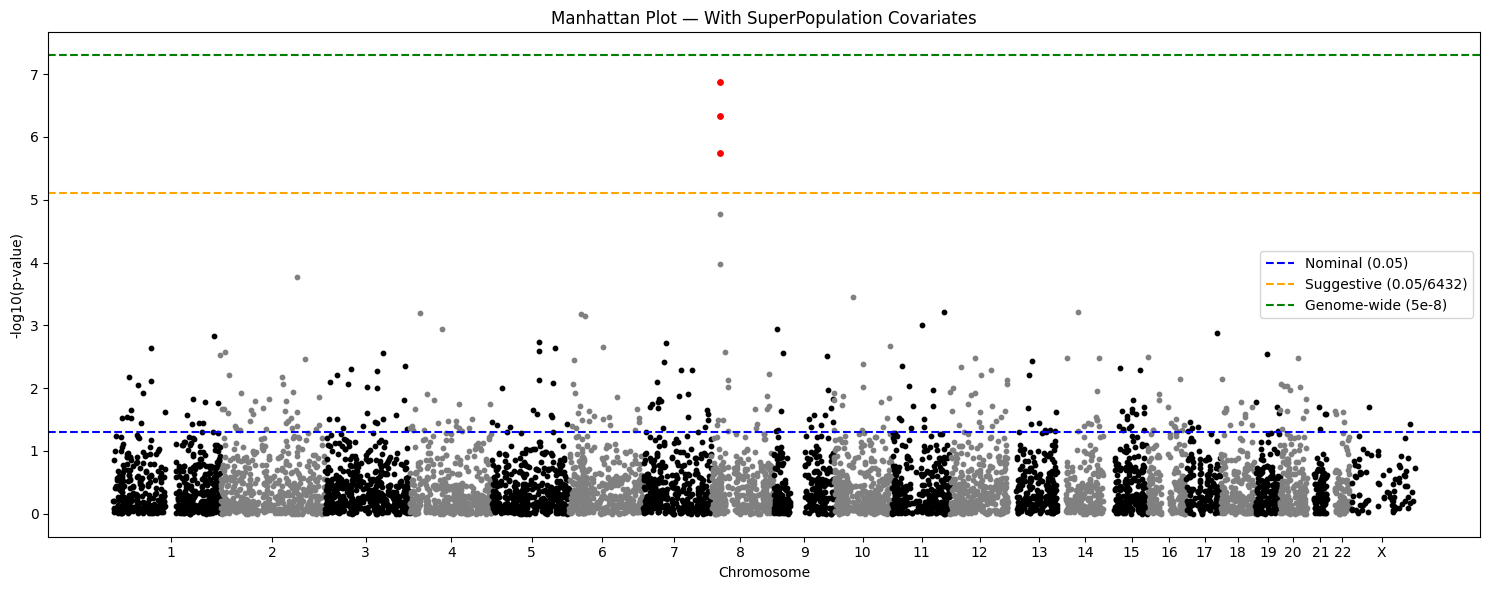

In [145]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = gwas_supop['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — With SuperPopulation Covariates")
plt.legend()
plt.tight_layout()
plt.show()

In [146]:
N = gwas_supop.shape[0]
n_nominal = (gwas_supop["pval"] < 0.05).sum()
n_suggestive = (gwas_supop["pval"] < 0.05 / N).sum()
n_genomewide = (gwas_supop["pval"] < 5e-8).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 327
SNPs passing suggestive (p < 0.05/N): 3
SNPs passing genome-wide (p < 5e-8): 0


#### i. Describe the results

**Answer:** 327 nominal SNPs is almost exactly what you would expect by random chance under the p < 0.05 threshold. This means that population structure caused most of the original false positives.

Nearly all suggestive associations disappear once you adjust for population group, showing that most of the signals in the uncorrected GWAS were driven by differences between superpopulations rather than real genotype–phenotype association.

The SNPs that looked genome-wide significant in the uncorrected GWAS were actually false positives driven by population differences. Once you add SuperPopulation as a covariate, these disappear completely.

Using SuperPopulation labels reduces most of the false-positive inflation from population structure, but it does not eliminate all of it. PCA-based correction removes substantially more structure, especially subtle differences within each superpopulation, leading to even fewer significant SNPs. Therefore, the PCA results show a cleaner, more conservative GWAS.

#### ii. Which approach would you prefer?

**Answer:** In general, PCA-based correction is preferred because principal components capture both broad and fine-scale genetic structure directly from the genotype data. SuperPopulation labels only adjust for very coarse, discrete groups and cannot account for subtle variation within each group. Therefore, PCA provides a more accurate and reliable correction for population stratification in GWAS.

# Step 5: GWAS meta-analysis

## 5a. MAF filtering per superpolutation

In [147]:
# Function to compute MAF from a 0/1/2 vector
def maf_from_vector(g):
    g = np.asarray(g, dtype=float)
    mask = np.isfinite(g)
    if mask.sum() == 0:
        return np.nan
    alt_count = np.nansum(g[mask])
    alt_freq = alt_count / (2 * mask.sum())
    return min(alt_freq, 1 - alt_freq)

MAF_THRESHOLD = 0.05

# Align genotype samples with annotation rows
ann_idx = annotations.set_index("Sample")

common_samples = geno_numeric.columns.intersection(ann_idx.index)
G = geno_numeric[common_samples]                     
pop_labels = ann_idx.loc[common_samples, "SuperPopulation"].astype(str).values
unique_pops = np.unique(pop_labels)

variants_per_pop = {}

print(f"Before filtering: {len(geno_numeric)} SNPs\n")

for pop in unique_pops:
    # Samples belonging to this super population
    sample_idx = np.where(pop_labels == pop)[0]
    G_sub = G.iloc[:, sample_idx]                    

    # MAF per SNP within this population
    mafs = np.apply_along_axis(maf_from_vector, 1, G_sub.values)
    keep_mask = mafs > MAF_THRESHOLD

    variants_per_pop[pop] = int(keep_mask.sum())
    print(f"{pop}: {variants_per_pop[pop]} variants with MAF > {MAF_THRESHOLD}")


Before filtering: 7991 SNPs

AFR: 6098 variants with MAF > 0.05
AMR: 6082 variants with MAF > 0.05
EAS: 5646 variants with MAF > 0.05
EUR: 5964 variants with MAF > 0.05
SAS: 6027 variants with MAF > 0.05


**Answer:** Each superpopulation have a different number of variants after filtering for MAF > 0.05 since allele frequencies vary across populations. A SNP that is common in one population can be rare in another. This can depend on demographic history, population size, and ancestral variation. This causes some populations (like EAS in this dataset) to have more SNPs falling below the 5% MAF threshold, while others retain more variants. This reflects real genetic differences between populations.

## 5b. GWAS per population using top 10 PCs as covariates


Superpopulation AFR


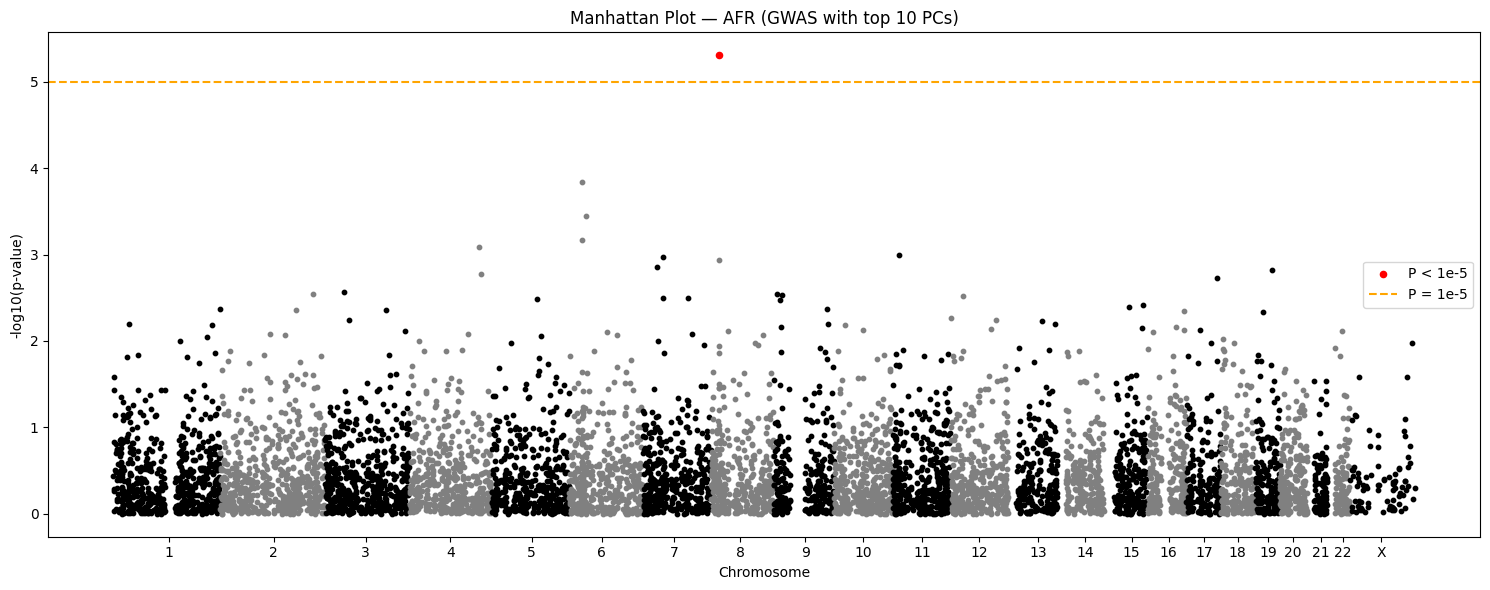


Superpopulation AMR


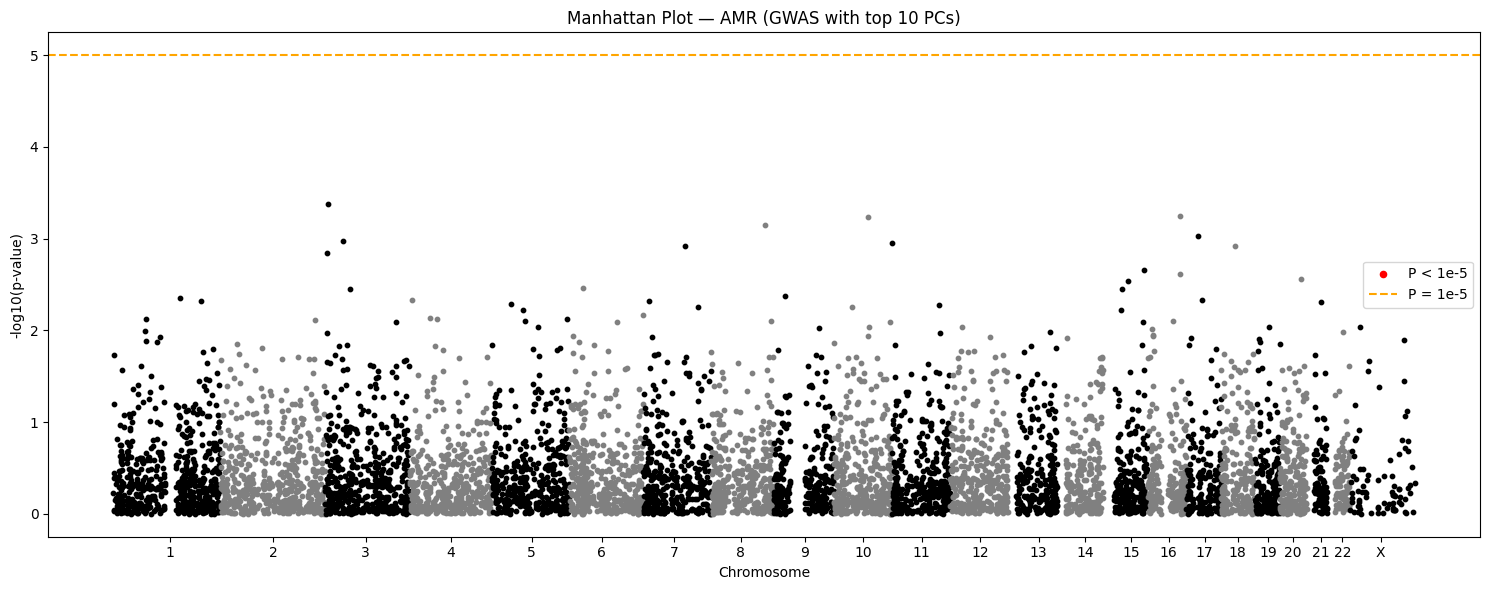


Superpopulation EAS


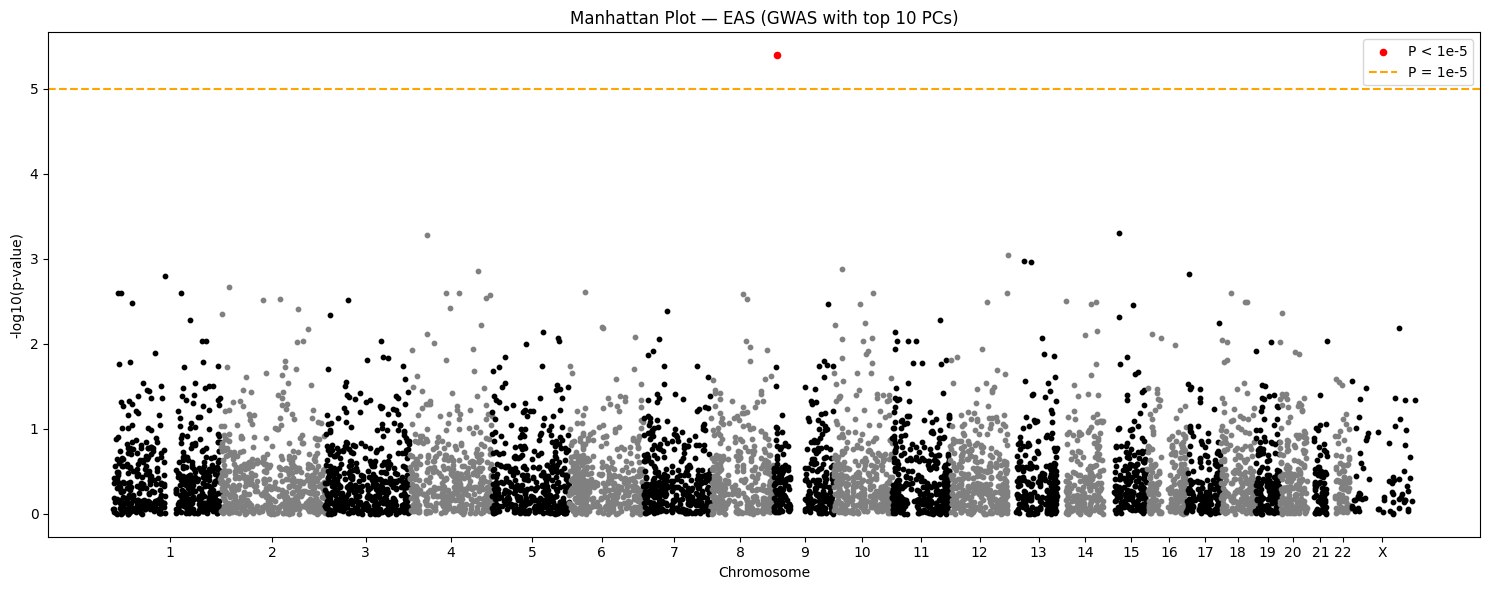


Superpopulation EUR


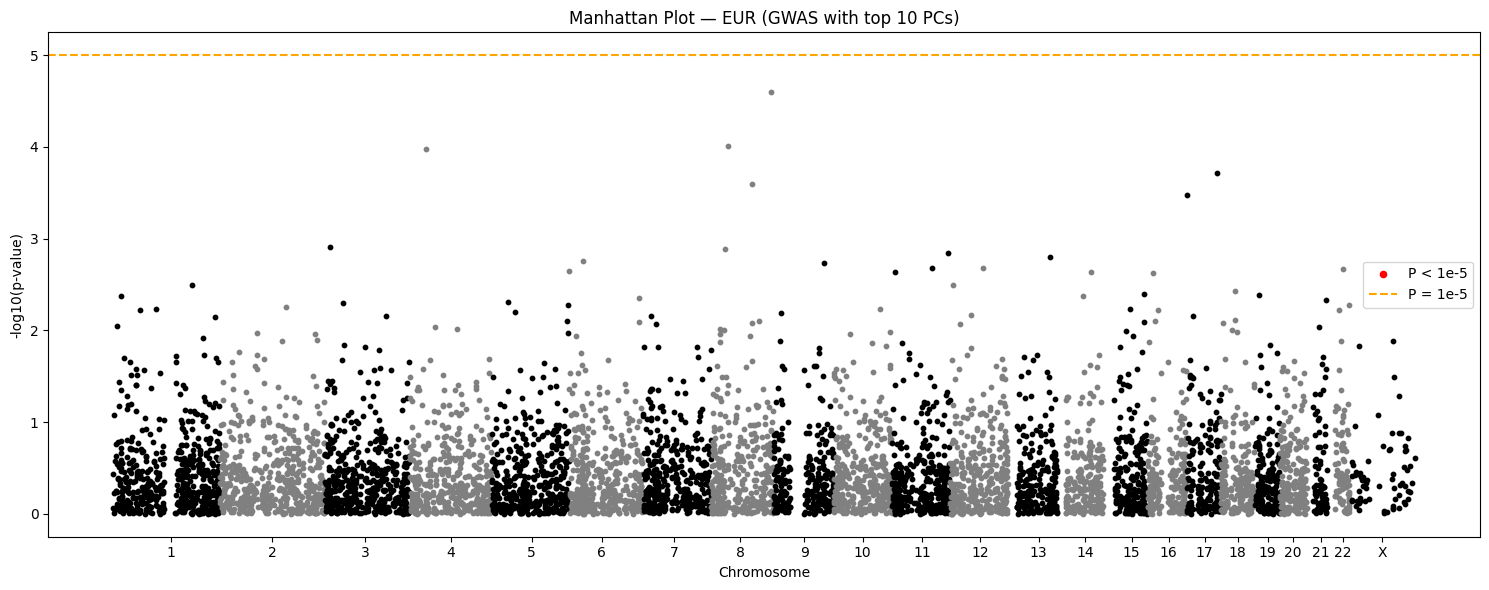


Superpopulation SAS


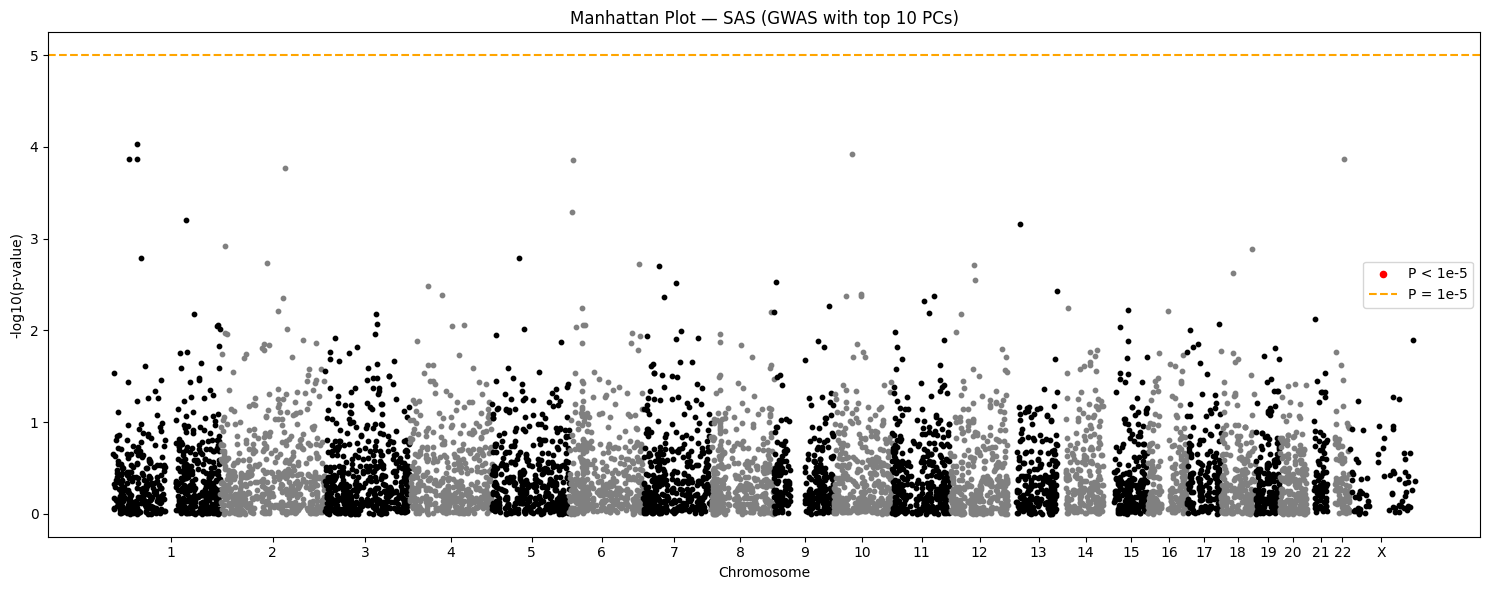

In [148]:
# Align annotations with genotype matrix
ann_all = annotations.set_index("Sample")

# Use genotypes after call-rate filtering
common_samples = geno_numeric.columns.intersection(ann_all.index)
G = geno_numeric[common_samples]

pop_labels = ann_all.loc[common_samples, "SuperPopulation"].astype(str).values
unique_pops = np.unique(pop_labels)

# Dictionary to store GWAS results per population
gwas_pop_pc10 = {}

## Loop through all populations
for pop in unique_pops:
    print(f"\nSuperpopulation {pop}")

    sample_idx = np.where(pop_labels == pop)[0]
    pop_samples = G.columns[sample_idx]

    # SNPs x samples in this population
    G_sub = G.loc[:, pop_samples]
    snps_use = G_sub.index

    # PCA on current population only (samples x SNPs)
    geno_for_pca = G_sub.T

    # PCA decomposition function from sklearn
    pca10_pop = decomposition.PCA(
        n_components=10,
        svd_solver="full",
        random_state=0
    )
    pcs_pop = pca10_pop.fit_transform(geno_for_pca.values)

    pc_cols = [f"PC{i}" for i in range(1, 11)]
    pcs_df = pd.DataFrame(
        pcs_pop,
        index=geno_for_pca.index,
        columns=pc_cols
    )

    # Phenotype for these samples
    ann_pop = ann_all.loc[geno_for_pca.index]
    pheno = ann_pop["CaffeineConsumption"]

    betas = []
    pvals = []
    snp_list = []

    # GWAS loop: one regression per SNP
    for snp in snps_use:
        geno_vec = G_sub.loc[snp]  # values across samples in this pop

        tmp = pd.concat(
            [
                pheno.rename("y"),
                geno_vec.rename("snp"),
                pcs_df
            ],
            axis=1
        ).dropna()

        # skip monomorphic SNPs in this population
        if tmp["snp"].nunique() < 2:
            betas.append(np.nan)
            pvals.append(np.nan)
            snp_list.append(snp)
            continue

        y = tmp["y"]
        X = tmp[["snp"] + pc_cols]
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()

        betas.append(model.params["snp"])
        pvals.append(model.pvalues["snp"])
        snp_list.append(snp)

    # Collect GWAS results for this population
    res_df = pd.DataFrame(
        {
            "beta": betas,
            "pval": pvals
        },
        index=snp_list
    )

    gwas_pop_pc10[pop] = res_df

    # Manhattan plot for this population

    # Get positions for these SNPs from call-rate-filtered VCF
    pos = vcf_filtered.loc[res_df.index, ["CHROM", "POS"]]
    df_plot = pos.join(res_df["pval"]).dropna()

    # Order chromosomes
    chrom_order = [str(i) for i in range(1, 23)] + ["X"]
    df_plot["CHROM"] = pd.Categorical(df_plot["CHROM"], categories=chrom_order, ordered=True)
    df_plot = df_plot.sort_values(["CHROM", "POS"])

    # Compute cumulative genomic position and -log10(p)
    df_plot["neglog10p"] = -np.log10(df_plot["pval"])

    chrom_sizes = df_plot.groupby("CHROM", observed=True)["POS"].max()
    chrom_start = (chrom_sizes.cumsum() - chrom_sizes).to_dict()
    df_plot["pos_cum"] = df_plot.apply(
        lambda row: row["POS"] + chrom_start[row["CHROM"]],
        axis=1
    )

    # Suggestive significance threshold: P = 1e-5
    p_suggestive = 1e-5
    thr_suggestive = -np.log10(p_suggestive)

    plt.figure(figsize=(15, 6))

    colors = ["black", "gray"]
    chroms = [c for c in chrom_order if c in df_plot["CHROM"].unique()]

    for i, chrom in enumerate(chroms):
        subset = df_plot[df_plot["CHROM"] == chrom]
        plt.scatter(
            subset["pos_cum"],
            subset["neglog10p"],
            s=10,
            color=colors[i % 2]
        )

    # highlight SNPs passing P < 1e-5
    sig_mask = df_plot["pval"] < p_suggestive
    plt.scatter(
        df_plot[sig_mask]["pos_cum"],
        df_plot[sig_mask]["neglog10p"],
        s=20,
        color="red",
        label="P < 1e-5"
    )

    # threshold line
    plt.axhline(thr_suggestive, color="orange", linestyle="--", label="P = 1e-5")

    # chromosome labels on x-axis
    chrom_mid = df_plot.groupby("CHROM", observed=True)["pos_cum"].mean()
    plt.xticks(chrom_mid.values, chrom_mid.index)

    plt.xlabel("Chromosome")
    plt.ylabel("-log10(p-value)")
    plt.title(f"Manhattan Plot — {pop} (GWAS with top 10 PCs)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 5c. Overlap of significant SNPs across populations

### i. Isolate SNPs and sum over individual population p-values

In [149]:
pops = list(gwas_pop_pc10.keys())

# Find SNPs that are common to all populations 
common_snps = None
for pop in pops:
    # SNPs with valid p-values in this population
    snps_pop = gwas_pop_pc10[pop].dropna(subset=["pval"]).index

    if common_snps is None:
        common_snps = set(snps_pop)
    else:
        common_snps &= set(snps_pop)

common_snps = sorted(common_snps)
print(f"Number of SNPs common to all populations: {len(common_snps)}")

# Build a table of p-values: rows = SNPs, columns = populations
meta_pvals = pd.DataFrame(index=common_snps, columns=pops, dtype=float)

for pop in pops:
    meta_pvals[pop] = gwas_pop_pc10[pop].loc[common_snps, "pval"]

p_val_sum = -2 * np.log(meta_pvals).sum(axis=1)

# Store in a meta-analysis results dataframe
meta_results = pd.DataFrame({
    "Sum over p-values": p_val_sum
}, index=common_snps)

meta_results.head()

Number of SNPs common to all populations: 5995


,Sum over p-values
4,5.983228
6,12.247001
7,12.282886
8,13.089261
10,11.301923


### ii. Compute population-wide p-value for each SNP

In [150]:
n_pops = len(pops)
df = 2 * n_pops

meta_pvals = 1 - stats.chi2.cdf(meta_results["Sum over p-values"], df=df)

meta_results["meta_pval"] = meta_pvals

print("\nNumber of SNPs with meta-analysis p < 1e-5:",
      (meta_results["meta_pval"] < 1e-5).sum())

meta_results.head()


Number of SNPs with meta-analysis p < 1e-5: 1


,Sum over p-values,meta_pval
4,5.983228,0.816670
6,12.247001,0.268866
7,12.282886,0.266570
8,13.089261,0.218724
10,11.301923,0.334484


### iii. Manhattan plot

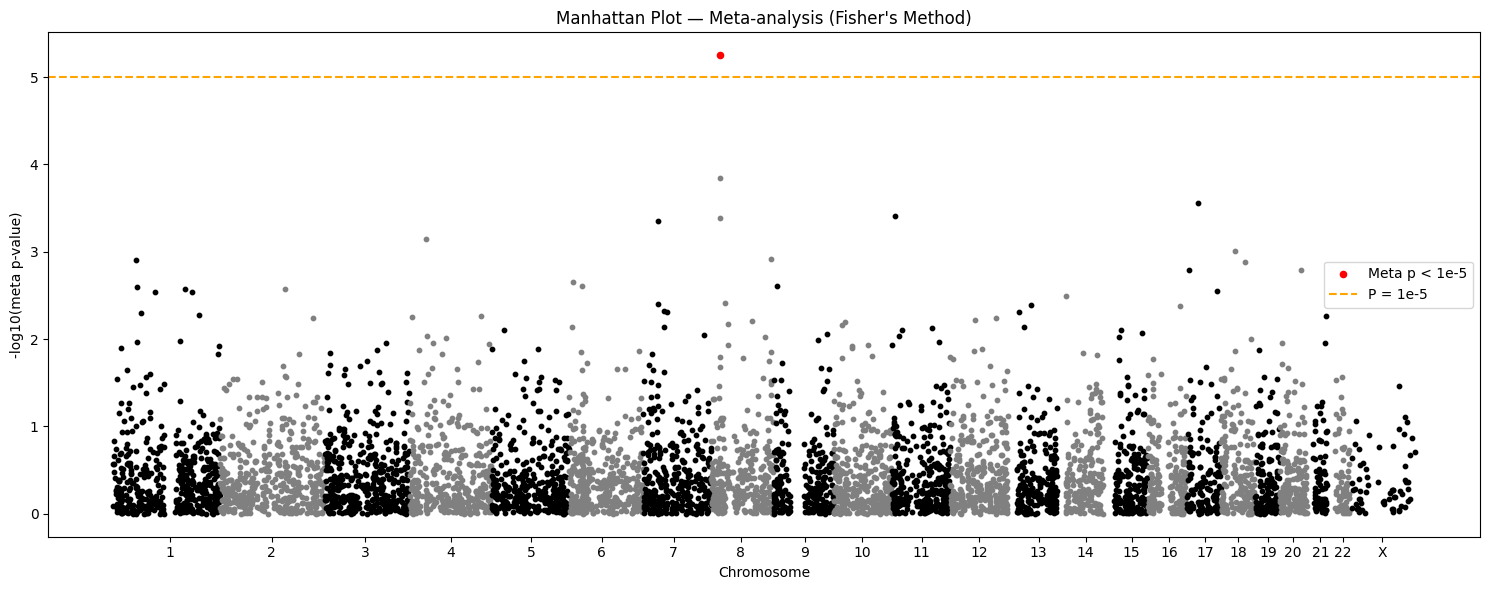

Number of SNPs with meta p < suggestive significance (1e-5): 1


In [151]:
# Join meta p-values with SNP positions
pos = vcf_filtered.loc[meta_results.index, ["CHROM", "POS"]]
df_meta = pos.join(meta_results["meta_pval"]).dropna()
df_meta = df_meta.rename(columns={"meta_pval": "pval"})

# Order chromosomes
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df_meta["CHROM"] = pd.Categorical(df_meta["CHROM"], categories=chrom_order, ordered=True)
df_meta = df_meta.sort_values(["CHROM", "POS"])

# Compute -log10(p) and cumulative genomic position
df_meta["neglog10p"] = -np.log10(df_meta["pval"])

chrom_sizes = df_meta.groupby("CHROM", observed=True)["POS"].max()
chrom_start = (chrom_sizes.cumsum() - chrom_sizes).to_dict()
df_meta["pos_cum"] = df_meta.apply(
    lambda row: row["POS"] + chrom_start[row["CHROM"]],
    axis=1
)

# Suggestive threshold P = 1e-5
p_suggestive = 1e-5
thr_suggestive = -np.log10(p_suggestive)

plt.figure(figsize=(15, 6))

# Alternating colors per chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df_meta["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df_meta[df_meta["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight SNPs with meta p < 1e-5
sig_mask = df_meta["pval"] < p_suggestive
plt.scatter(
    df_meta[sig_mask]["pos_cum"],
    df_meta[sig_mask]["neglog10p"],
    s=20,
    color="red",
    label="Meta p < 1e-5"
)

# Threshold line
plt.axhline(thr_suggestive, color="orange", linestyle="--", label="P = 1e-5")

# X-axis ticks at chromosome midpoints
chrom_mid = df_meta.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(meta p-value)")
plt.title("Manhattan Plot — Meta-analysis (Fisher's Method)")
plt.legend()
plt.tight_layout()
plt.show()

print("Number of SNPs with meta p < suggestive significance (1e-5):",
      (df_meta["pval"] < p_suggestive).sum())

## 5d. How do significant SNPs and p-values based on our meta-analysis differ compared to 4e?

**Answer:** The meta-analysis tests only SNPs that pass the MAF filter in every population, so there a fewer SNPs included than in section 4e (only 1). Since Fisher's method combines evidence across populations, SNPs that show consistent effects in all groups often become more significant, while SNPs coming mainly from one population become less significant. This causes the pattern of significant SNPs to differ from the GWAS in 4e, which is more influenced by populations structure and uneven sample size.

# Section 6: Functional Analysis

## 6a. What is the rsid and what is(are) the top assiciated gene(s) for this SNP?

**Answer:** The rsid is rs2472297. The top 2 associated genes for this SNP are CYP1A1 and CYP1A2.

## 6b. What evidence was used to determine the SNP-to-gene association (s)?

**Answer:** The main evidence that was used to determine the association according to the Open Targets page was genomic distance (DistanceVEP). There were also smaller contributions from eQTL, pQTL and sQTL. Then, some other unnamed factores played a small role.

# Optional: Fisher's Method

## I. Show with density plot that uniform and transformed values follow Chi2 distribution

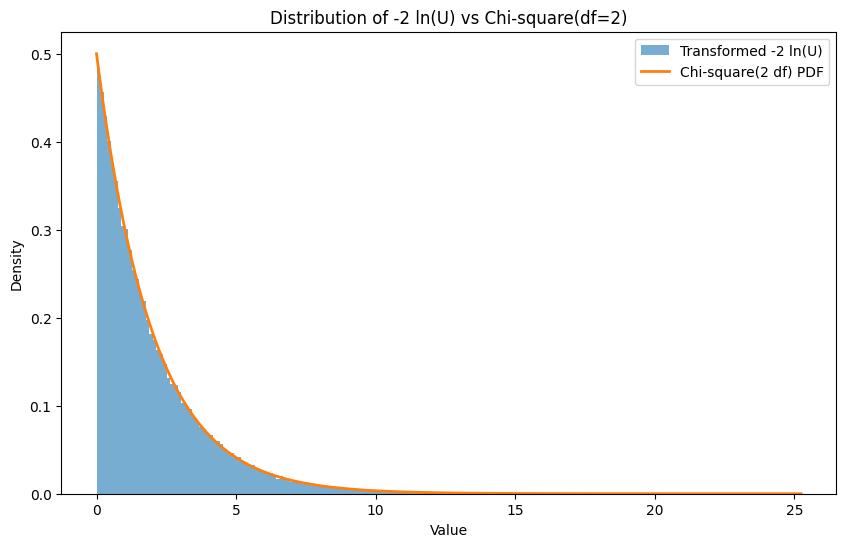

In [152]:
# Set reproducibility
np.random.seed(0)

# Generate values from a uniform distribution U(0,1)
n = 100000
u = np.random.uniform(0, 1, n)

# Apply the Fisher transform: X = -2 ln(U)
x = -2 * np.log(u)

# Plot histogram of transformed values
plt.figure(figsize=(10,6))
plt.hist(x, bins=200, density=True, alpha=0.6, label='Transformed -2 ln(U)')

# Overlay theoretical Chi-square(2 df) density curve
x_vals = np.linspace(0, np.max(x), 1000)
plt.plot(x_vals, stats.chi2.pdf(x_vals, df=2),
         linewidth=2, label='Chi-square(2 df) PDF')

# Labels
plt.title("Distribution of -2 ln(U) vs Chi-square(df=2)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


## II. Show sum of 5 U(0,1) follows Chi2 (df=2*5)

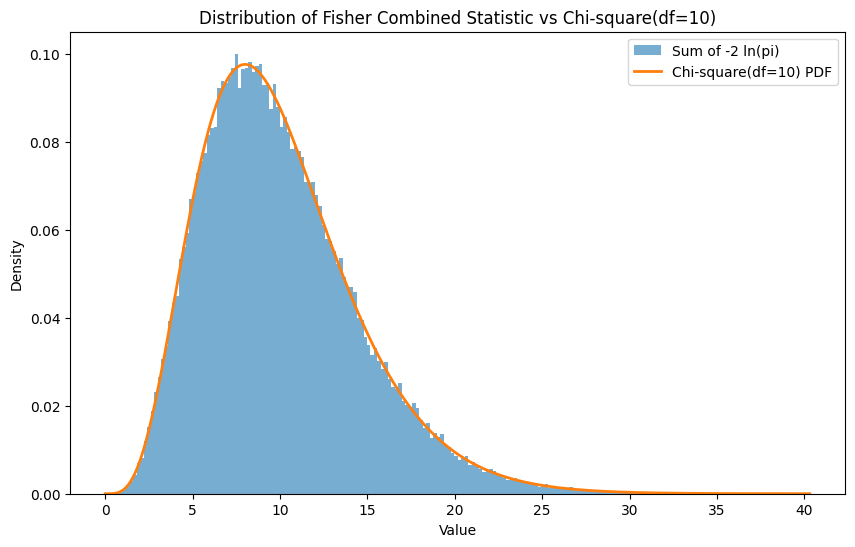

In [153]:
# Set reproducibility
np.random.seed(0)

# Generate 5 sets of uniform(0,1)
n = 100000
p1 = np.random.uniform(0, 1, n)
p2 = np.random.uniform(0, 1, n)
p3 = np.random.uniform(0, 1, n)
p4 = np.random.uniform(0, 1, n)
p5 = np.random.uniform(0, 1, n)

# Apply Fisher's combined transform:
#    Y = -2 * (ln(p1) + ... + ln(p5))
Y = -2 * (np.log(p1) + np.log(p2) + np.log(p3) + np.log(p4) + np.log(p5))

# Plot the histogram of the combined values
plt.figure(figsize=(10,6))
plt.hist(Y, bins=200, density=True, alpha=0.6, label='Sum of -2 ln(pi)')

# Overlay theoretical Chi-square(df=10)
x_vals = np.linspace(0, np.max(Y), 1000)
plt.plot(x_vals, stats.chi2.pdf(x_vals, df=10),
         linewidth=2, label='Chi-square(df=10) PDF')

plt.title("Distribution of Fisher Combined Statistic vs Chi-square(df=10)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

## III. Find combination of 5 p-values that results in significant final p-value

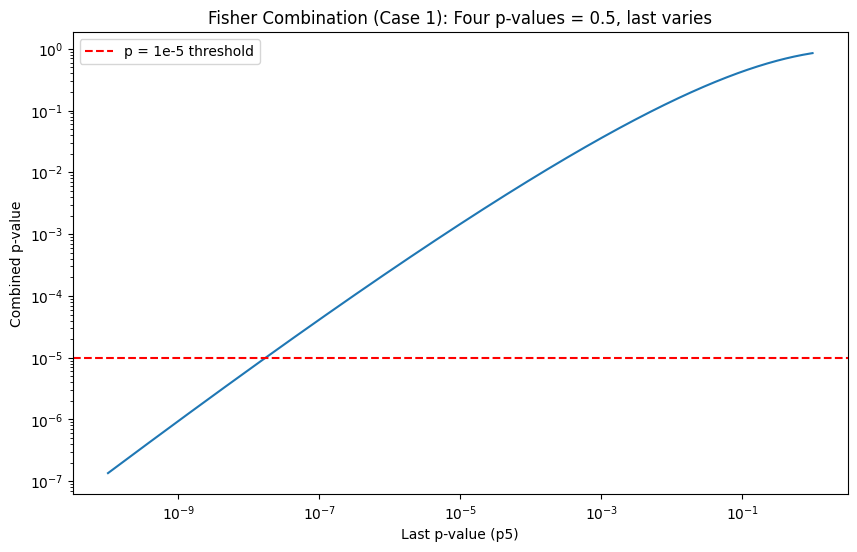

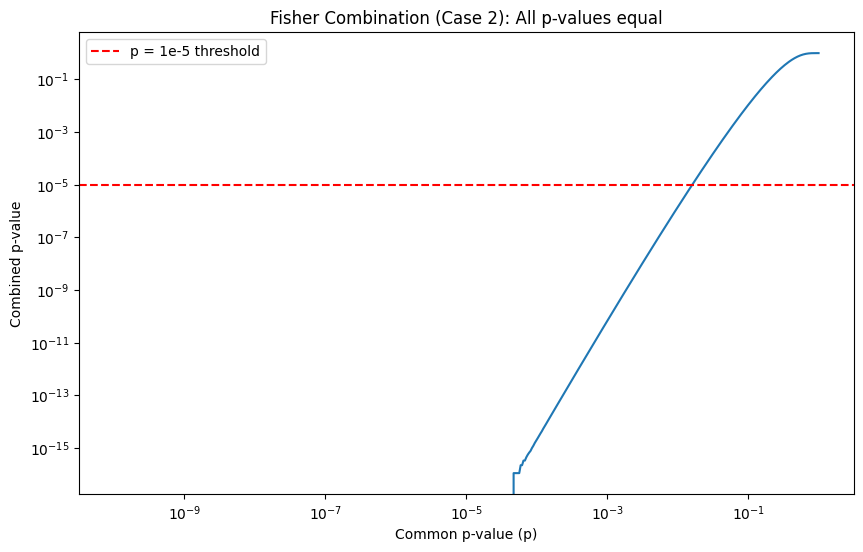

Case 1: p5 must be < 1.677e-08
Case 2: each p must be < 1.572e-02


In [154]:
# Fisher combine function
def fisher_pvalue(ps):
    X = -2 * np.sum(np.log(ps))
    p_comb = 1 - stats.chi2.cdf(X, df=2*len(ps))
    return X, p_comb

# -----------------------------
# Case 1: four p-values = 0.5
# -----------------------------
p_last_values = np.logspace(-10, 0, 500)   # from 1e-10 to 1
combined_p_case1 = []

for p5 in p_last_values:
    ps = np.array([0.5, 0.5, 0.5, 0.5, p5])
    X, p_comb = fisher_pvalue(ps)
    combined_p_case1.append(p_comb)

combined_p_case1 = np.array(combined_p_case1)

# -----------------------------
# Case 2: all 5 p-values equal
# -----------------------------
p_all_values = np.logspace(-10, 0, 500)
combined_p_case2 = []

for p in p_all_values:
    ps = np.array([p, p, p, p, p])
    X, p_comb = fisher_pvalue(ps)
    combined_p_case2.append(p_comb)

combined_p_case2 = np.array(combined_p_case2)

# -----------------------------
# Plot Case 1
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(p_last_values, combined_p_case1)
plt.axhline(1e-5, color='r', linestyle='--', label='p = 1e-5 threshold')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Last p-value (p5)")
plt.ylabel("Combined p-value")
plt.title("Fisher Combination (Case 1): Four p-values = 0.5, last varies")
plt.legend()
plt.show()

# -----------------------------
# Plot Case 2
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(p_all_values, combined_p_case2)
plt.axhline(1e-5, color='r', linestyle='--', label='p = 1e-5 threshold')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Common p-value (p)")
plt.ylabel("Combined p-value")
plt.title("Fisher Combination (Case 2): All p-values equal")
plt.legend()
plt.show()

# -----------------------------
# Print thresholds
# -----------------------------
# Case 1: largest p5 that gets below 1e-5
idx1 = np.where(combined_p_case1 < 1e-5)[0][-1]
print(f'Case 1: p5 must be < {p_last_values[idx1]:.3e}')

# Case 2: largest common p that gets below 1e-5
idx2 = np.where(combined_p_case2 < 1e-5)[0][-1]
print(f'Case 2: each p must be < {p_all_values[idx2]:.3e}')


## IV. List 3 reasons why we might not be able to assume independent random variables

One reason is sample overlap or related individuals across groups. If the same individual or close relatives appear in more than one population cohort, the test statistics (and thus p-values) are correlated because they’re partly based on the same genotype/phenotype data.

Another reason is shared ancestry or population structure and correlated allele frequencies. Different populations are not independent random samples because they share demographic history. These create correlations in allele frequencies and LD patterns across populations, which gives correlated test statistics for the same SNP.

Another reason is correlated environmental effects or phenotype measurement differences. If environmental exposures, phenotype definitions, or measurement errors are correlated across populations, the phenotype–genotype associations will be correlated across cohorts even if genotypes differ.